In [1]:
from keras.layers import LSTM
from keras.models import Sequential, Model
from keras.layers import Dense, Activation,Input,InputLayer, Add, Masking, Embedding, RepeatVector, BatchNormalization, concatenate, Dropout, TimeDistributed
from keras.optimizers import RMSprop
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
featurelen=2048
dictlen=8495
sentencelen=39
EMBEDDING_DIM=512
visibletime=1

In [3]:
def get_model(featurelen=4096, dictlen=8495, sentencelen=39, EMBEDDING_DIM=512):
    dummy_model=Sequential()
    dummy_model.add(InputLayer(input_shape=(EMBEDDING_DIM,)))
    dummy_model.add(RepeatVector(sentencelen-visibletime))


    image_model = Sequential()
    image_model.add(Dense(EMBEDDING_DIM, input_dim = (featurelen), activation='elu'))
    image_model.add(BatchNormalization())
    imageout=image_model.output
    imageout=RepeatVector(visibletime)(imageout)

    b=concatenate([imageout,dummy_model.output],axis=1)

    # b = Lambda(lambda x: backend.concatenate([x,mask],axis=1),output_shape=(sentencelen,featurelen))(imageout)
    # image_model.add(RepeatVector(sentencelen))

    lang_model = Sequential()
    # lang_model.add(InputLayer(input_shape=(1,sentencelen)))
    # lang_model.add(Masking(mask_value=-1))
    lang_model.add(Embedding(dictlen, 256, input_length=sentencelen))
    lang_model.add(BatchNormalization())
    # lang_model.add(TimeDistributed(Dense(128)))
    lang_model.add(LSTM(256,return_sequences=True))
    lang_model.add(BatchNormalization())
    lang_model.add(Dropout(0.3))
    lang_model.add(TimeDistributed(Dense(EMBEDDING_DIM)))
    lang_model.add(BatchNormalization())

    intermediate = concatenate([ lang_model.output,b])
    # intermediate = (Dropout(0.1))(intermediate)
    # intermediate = LSTM(1024,return_sequences=True,dropout=0.5)(intermediate)
    # intermediate = BatchNormalization()(intermediate)
    # intermediate = (Dropout(0.3))(intermediate)
    intermediate = LSTM(1536,return_sequences=True,dropout=0.5)(intermediate)
    intermediate = BatchNormalization()(intermediate)
    intermediate = (Dropout(0.3))(intermediate)
    intermediate = TimeDistributed(Dense(dictlen,activation='softmax'))(intermediate)

    model=Model(inputs=[image_model.input,dummy_model.input,lang_model.input],outputs=intermediate)
#     print model.summary()

    model.compile(optimizer = "rmsprop",loss='categorical_crossentropy',metrics=['accuracy'])

    return model

In [4]:
from gen_dummy import Generator
batch_size = 256
gen = Generator(batch_size, max_token_len = 39, img_fea_size = 2048, feature_file = "InceptionV3_features.h5")
model = get_model(gen.feature_size, gen.vocab_size, gen.max_token_len, 512 )

In [88]:
print "Now Training"
model.fit_generator(gen.pullData(), epochs=2, steps_per_epoch=int(gen.training_samples_count / batch_size) )

Now Training
Epoch 1/2
158/158 [==============================] - 194s 1s/step - loss: 0.7414 - acc: 0.8396
Epoch 2/2
158/158 [==============================] - 193s 1s/step - loss: 0.7198 - acc: 0.8424


In [140]:
model.save('singleLSTm=10epochs.h5')

In [23]:
from keras.models import load_model

model = load_model('singleLSTm=4epochs.h5')

In [132]:

from IPython.display import Image

img_name = '1479857177_9d4a6f38fd.jpg'
img_path = 'Flickr8k_Dataset/'+ img_name

import numpy as np

import h5py
feature_dataset = h5py.File('InceptionV3_features.h5', 'r')
img_features = feature_dataset[img_name]['cnn_features'][:]
print img_features
features = np.array([img_features])

text_in = np.zeros((1,gen.max_token_len))
text_in[0][:] = np.full((gen.max_token_len,), 0)
text_in[0][0] = 4231

dummy_zeros = np.zeros((1,512))

# print features,text_in
arr = []
for arg in range(gen.max_token_len-1):
    pred = model.predict([features, dummy_zeros, text_in])
    tok = np.argmax(pred[0][arg])
    word = gen.id_to_token[tok]
    text_in[0][arg+1] = tok
    arr.append(word)
#     if word == '<end>':
#         break

print ' '.join(arr)
Image(filename=img_path) 


KeyError: "Unable to open object (object '1479857177_9d4a6f38fd.jpg' doesn't exist)"

In [ ]:
3621652774_fd9634bd5b.jpg
1897025969_0c41688fa6
2707835735_6537b27e8f
2870875612_2cbb9e4a3c
2512682478_b67cc525c7
3484820303_7be0e914b4
531261613_f1a045cd75
1082379191_ec1e53f996
3364258732_9942c557e5
970641406_9a20ee636a
466956209_2ffcea3941
2705793985_007cc703fb

In [20]:
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

base_model = InceptionV3(weights='imagenet')
img_model =  Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)


/home/shanmukh.alle/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("av..., inputs=Tensor("in...)`
  import sys


In [138]:
img_input = []
img_path = 'Flickr8k_Dataset/'+ '1797554350_20998753c0.jpg'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
img_input.append(np.squeeze(x))

img_input = np.asarray(img_input)
features = img_model.predict(img_input, batch_size = 128)

<P> at a girl in a red skirt <end> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


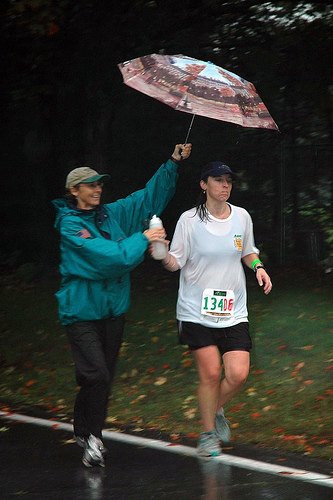

In [139]:
from IPython.display import Image

import numpy as np

text_in = np.zeros((1,gen.max_token_len))
text_in[0][:] = np.full((gen.max_token_len,), 0)
text_in[0][0] = 4231

dummy_zeros = np.zeros((1,512))

# print features,text_in
arr = []
for arg in range(gen.max_token_len-1):
    pred = model.predict([features, dummy_zeros, text_in])
    tok = np.argmax(pred[0][arg])
    word = gen.id_to_token[tok]
    text_in[0][arg+1] = tok
    arr.append(word)
#     if word == '<end>':
#         break

print ' '.join(arr)
Image(filename=img_path) 


In [67]:
274691778_94bb57bba3
1468103286_96a6e07029
3535664885_c848c0faee
1797554350_20998753c0
2714703706_d21c5cb8df
3479245321_6a5bc470f8
2136455112_202c093ba4
3333039854_461329aac2
3599392711_8264881de2
199463720_329a802206
3664928753_7b0437fedf
3246804978_ea2c9e56f2
1479857177_9d4a6f38fd
3640109324_3ce89e4d1a
2895966469_53e0b29295

SyntaxError: invalid syntax (<ipython-input-67-ded91d507ebc>, line 1)